In [8]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from config import *
from utils import *
import os

In [9]:
dimension=3
instance_count=100


In [10]:
visualization_dir='feature_visualizations'

result_dir='algorithm_classification_results'

In [11]:
algorithm_names=['DE','PSO','ES']
#algorithm_names= [f'DE_CR_{CR}_crossover_{crossover}' for CR in [0.2, 0.4, 0.6, 0.8] for crossover in ['exp','bin']]
seeds=[200,400,600,800,1000]
seed_mapping={s:s_idx for s_idx,s in enumerate(seeds)}
seeds_mapped=[seed_mapping[s] for s in seeds]
iteration_min,iteration_max=0,49

In [21]:
feature_df_file=f'{result_dir}/dim_{dimension}_{"-".join(algorithm_names)}_seeds_{"-".join([str(s) for s in seeds])}_it_{iteration_min}-{iteration_max}'
if os.path.isfile(feature_df_file) and False:
    print('reading features from file')
    feature_df=pd.read_csv(feature_df_file)
    feature_df['seed']=feature_df['seed'].apply(lambda s:seed_mapping[s])
    feature_df=feature_df.set_index(['algorithm_name','problem_id','instance_id','seed'])
    
else:
    sample_df=read_trajectory_data(algorithm_names, seeds, dimension)
    feature_df = extract_features(sample_df, dimension, iteration_min,iteration_max)


    #feature_df.to_csv(feature_df_file)

#feature_names=[f'{j}_it_{it}_' + (f'x_{i}' if i < dimension else 'y') for it in range(iteration_min, iteration_max+1)  for j in ['mean','min','max','std'] for i in range(0,dimension+1) ]  

(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
(3600000, 8)
Function extract_features Took 138.9745 seconds


In [22]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black','#008b8b','#9acd32','#e3f8b7'])


In [23]:
differenced_feature_df=difference_features(feature_df,iteration_max)

In [24]:
def plot_df(feature_df, algorithm_name, problem_id, instance_id, seed):
    df = feature_df.loc[(algorithm_name, problem_id, instance_id, seed),:]
    x = df.to_frame().T.drop(columns=['y'])

    stats=[]
    for c,value in x.to_dict(orient='records')[0].items():
        c_split=c.split('_')

        stats+=[(c_split[0], c_split[2], c_split[4],value)]
    d=pd.DataFrame(stats,columns=['aggregate','iteration','dimension','value'])

    fig, axes = plt.subplots(1,4,sharex=True, squeeze=True, figsize=(28,4))
    for i,dim in enumerate(d['dimension'].drop_duplicates().values):
        d_dim=d.query("dimension==@dim")
        sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[i])
    fig_name=f'{algorithm_name}_pid_{problem_id}_iid_{instance_id}_s_{seed}'
    plt.tight_layout()
    plt.savefig(f'{visualization_dir}/{fig_name}.pdf')
    plt.show()
    

In [25]:
def get_df_to_plot(feature_df, algorithm_name, problem_id, instance_id, seed, difference):
    df = feature_df.loc[(algorithm_name, problem_id, instance_id, seed),:]
    x = df.to_frame().T.drop(columns=['y'])

    stats=[]
    for c,value in x.to_dict(orient='records')[0].items():
        if difference:
            its_split=c.split(' - ')
            aggregate=its_split[0].split('_')[0]
            its = its_split[0].split('_')[2] + '-' + its_split[1].split('_')[2] 
            dimension = its_split[0].split('_')[4]
            stats+=[(aggregate, its, dimension,value)]
        else:
            c_split=c.split('_')
            stats+=[(c_split[0], c_split[2], c_split[4],value)]
    d=pd.DataFrame(stats,columns=['aggregate','iteration','dimension','value'])
    return d
    

In [67]:
def plot_multiple_algorithm_trajectories(ds, subplot_titles, fig_name):
    
    fig, axes = plt.subplots(len(ds),dimension+1, sharex=True, figsize=(3*dimension,int(2.5*(len(ds))) ))
    
    for j, d in enumerate(ds):
        all_dimensions=d['dimension'].drop_duplicates().values
        for i,dim in enumerate(all_dimensions):
            if i==1:
                axes[j][i].title.set_text('                 ' + subplot_titles[j])
            d_dim=d.query("dimension==@dim")
            a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
            a.set_ylabel(f'x_{dim}' if i!=len(all_dimensions)-1 else 'y')
            a.tick_params(axis='x', labelrotation=90)
            #a.set_xticklabels(list(range(1,31)))
            n = 5  # Keeps every 7th label
            [l.set_visible(False) for (i,l) in enumerate(a.xaxis.get_ticklabels()) if i % n != 0]
            
            if i==len(all_dimensions)-1 and j ==len(ds)-1:
                a.legend(title='Aggregation')
            else:
                a.get_legend().remove()
                
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.savefig(f'{visualization_dir}/{fig_name}.pdf')
    plt.show()

In [68]:
def plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot, dimensions_to_plot=None,difference=False):
    fig_name=f'dim_{dimension}_algs_{"-".join(algorithm_names_to_plot)}_pids_{"-".join([str(p) for p in problem_ids_to_plot])}_iids_{"-".join([str(i) for i in instance_ids_to_plot])}_seeds_{"-".join([str(s) for s in seeds_to_plot])}_differenced_{difference}'

    ds = [get_df_to_plot(feature_df if not difference else differenced_feature_df, algorithm_name=algorithm_name_to_plot, problem_id=problem_id_to_plot, instance_id=instance_id_to_plot, seed=seed_to_plot, difference=difference)
         for algorithm_name_to_plot in algorithm_names_to_plot
         for problem_id_to_plot in problem_ids_to_plot
         for instance_id_to_plot in instance_ids_to_plot
         for seed_to_plot in seeds_to_plot
         ]
    print(ds)
    subplot_titles=[f'Algorithm: {algorithm_name_to_plot} Problem: {problem_id_to_plot} Instance: {instance_id_to_plot} Seed: {seed_to_plot}'
         for algorithm_name_to_plot in algorithm_names_to_plot
         for problem_id_to_plot in problem_ids_to_plot
         for instance_id_to_plot in instance_ids_to_plot
         for seed_to_plot in seeds_to_plot
         ]
    plot_multiple_algorithm_trajectories(ds, subplot_titles, fig_name)

In [78]:
iterations = [f'_it_{i}_' for i in range(0,30)]

In [80]:
first_iteration_features=list(filter(lambda c: np.any([f in c for f in iterations]), feature_df.columns))

In [83]:
feature_df=feature_df[first_iteration_features+['y']]

[    aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3  106.169357
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3   79.481128
476       std        29         0    0.005374
477       std        29         1    0.009560
478       std        29         2    0.005219
479       std        29         3    0.000232

[480 rows x 4 columns],     aggregate iteration dimension         value
0        mean         0         0  1.266517e-02
1        mean         0         1 -1.962060e-02
2        mean         0         2  1.691951e-02
3        mean         0         3  1.927550e+07
4         min         0         0 -4.759106e+00
..        ...       ...       ...           ...
475       max        29         3 -1.908836e+02
476       std        29         0  3.7

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

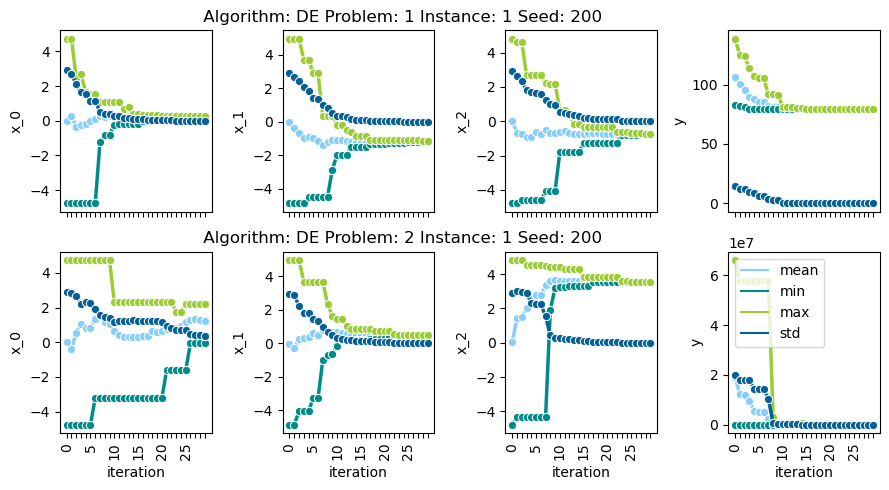

In [84]:
algorithm_names_to_plot=['DE']
problem_ids_to_plot=[1,2]
instance_ids_to_plot=[1]
seeds_to_plot=[200]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=False)

[    aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3  106.169357
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3   79.481128
476       std        29         0    0.005374
477       std        29         1    0.009560
478       std        29         2    0.005219
479       std        29         3    0.000232

[480 rows x 4 columns],     aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3  457.394561
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3  394.480980
476       std        29         0    0.007987
477     

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

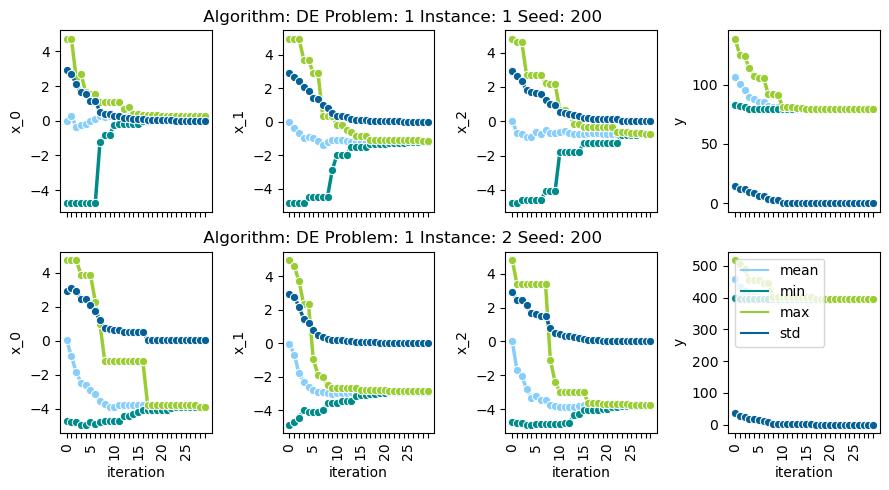

In [85]:
algorithm_names_to_plot=['DE']
problem_ids_to_plot=[1]
instance_ids_to_plot=[1,2]
seeds_to_plot=[200]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=False)

[    aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3  106.169357
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3   79.481128
476       std        29         0    0.005374
477       std        29         1    0.009560
478       std        29         2    0.005219
479       std        29         3    0.000232

[480 rows x 4 columns],     aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3  457.394561
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3  394.480980
476       std        29         0    0.007987
477     

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

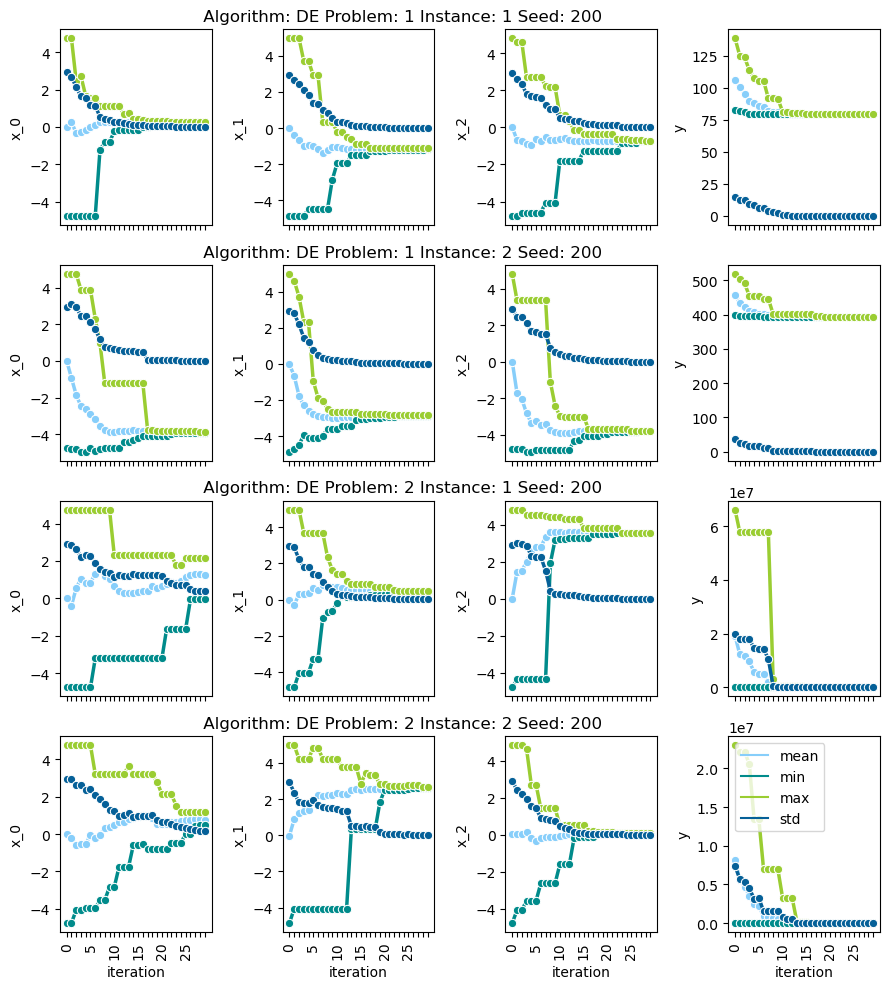

In [86]:
algorithm_names_to_plot=['DE']
problem_ids_to_plot=[1,2]
instance_ids_to_plot=[1,2]
seeds_to_plot=[200]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=False)

[    aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3 -251.113318
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3 -451.303735
476       std        29         0    0.368325
477       std        29         1    0.197191
478       std        29         2    0.249600
479       std        29         3    2.663747

[480 rows x 4 columns],     aggregate iteration dimension       value
0        mean         0         0    0.012665
1        mean         0         1   -0.019621
2        mean         0         2    0.016920
3        mean         0         3 -251.113318
4         min         0         0   -4.759106
..        ...       ...       ...         ...
475       max        29         3 -461.310888
476       std        29         0    0.026047
477     

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

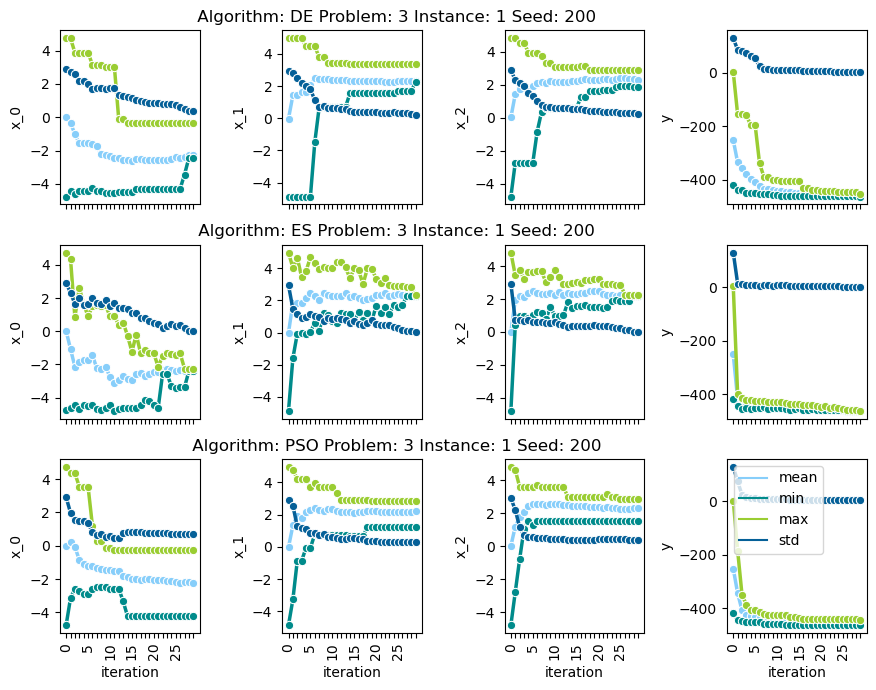

In [88]:
algorithm_names_to_plot=['DE','ES','PSO']
problem_ids_to_plot=[3]
instance_ids_to_plot=[1]
seeds_to_plot=[200]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=False)

[    aggregate iteration dimension         value
0        mean       1-0         0  2.604986e-01
1        mean       1-0         1 -3.508172e-01
2        mean       1-0         2 -7.011279e-01
3        mean       1-0         3 -5.544543e+00
4         min       1-0         0  0.000000e+00
..        ...       ...       ...           ...
779       max     49-48         3  0.000000e+00
780       std     49-48         0 -3.520240e-06
781       std     49-48         1 -3.213666e-06
782       std     49-48         2 -7.052583e-06
783       std     49-48         3  5.037257e-10

[784 rows x 4 columns],     aggregate iteration dimension         value
0        mean       1-0         0 -2.887790e-02
1        mean       1-0         1 -1.012108e+00
2        mean       1-0         2 -5.219604e-01
3        mean       1-0         3 -6.248406e+00
4         min       1-0         0  0.000000e+00
..        ...       ...       ...           ...
779       max     49-48         3  0.000000e+00
780       std 

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

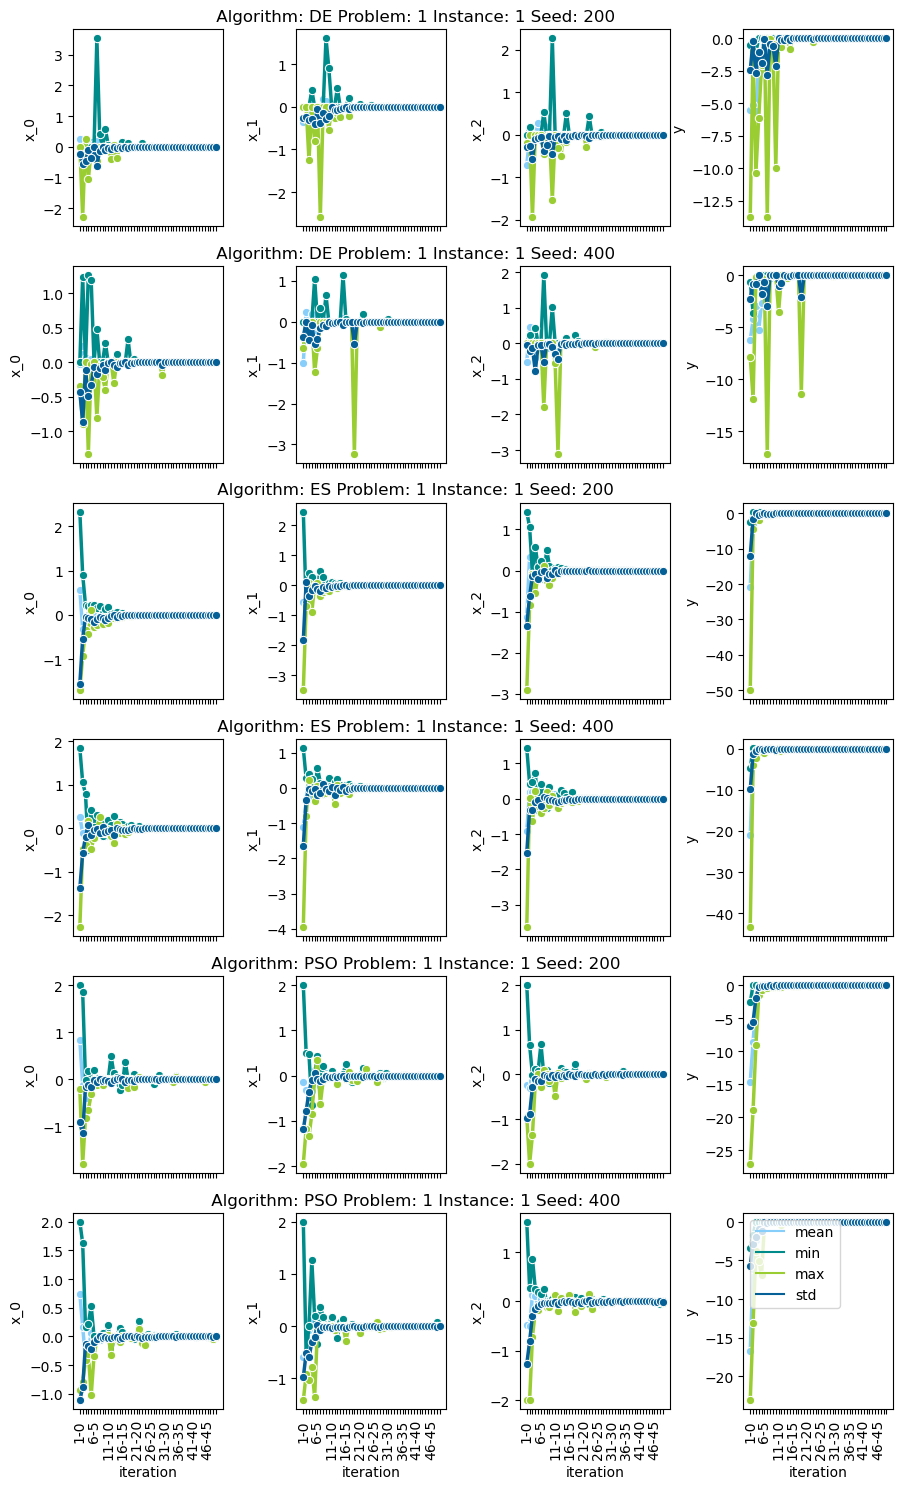

In [74]:
algorithm_names_to_plot=['DE','ES','PSO']
problem_ids_to_plot=[1]
instance_ids_to_plot=[1]
seeds_to_plot=[200,400]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=True)

[    aggregate iteration dimension         value
0        mean       1-0         0  2.604986e-01
1        mean       1-0         1 -3.508172e-01
2        mean       1-0         2 -7.011279e-01
3        mean       1-0         3 -5.544543e+00
4         min       1-0         0  0.000000e+00
..        ...       ...       ...           ...
779       max     49-48         3  0.000000e+00
780       std     49-48         0 -3.520240e-06
781       std     49-48         1 -3.213666e-06
782       std     49-48         2 -7.052583e-06
783       std     49-48         3  5.037257e-10

[784 rows x 4 columns],     aggregate iteration dimension         value
0        mean       1-0         0  5.670224e-01
1        mean       1-0         1 -5.700464e-01
2        mean       1-0         2 -1.121854e+00
3        mean       1-0         3 -2.077287e+01
4         min       1-0         0  2.334680e+00
..        ...       ...       ...           ...
779       max     49-48         3 -1.447802e-10
780       std 

/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axes[j][i], palette=color_palette,linewidth = 2.5,marker="o" )
/tmp/ipykernel_3739/1693281660.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  a=sns.lineplot(d_dim, x="iteration", y="value", hue='aggregate', ax=axe

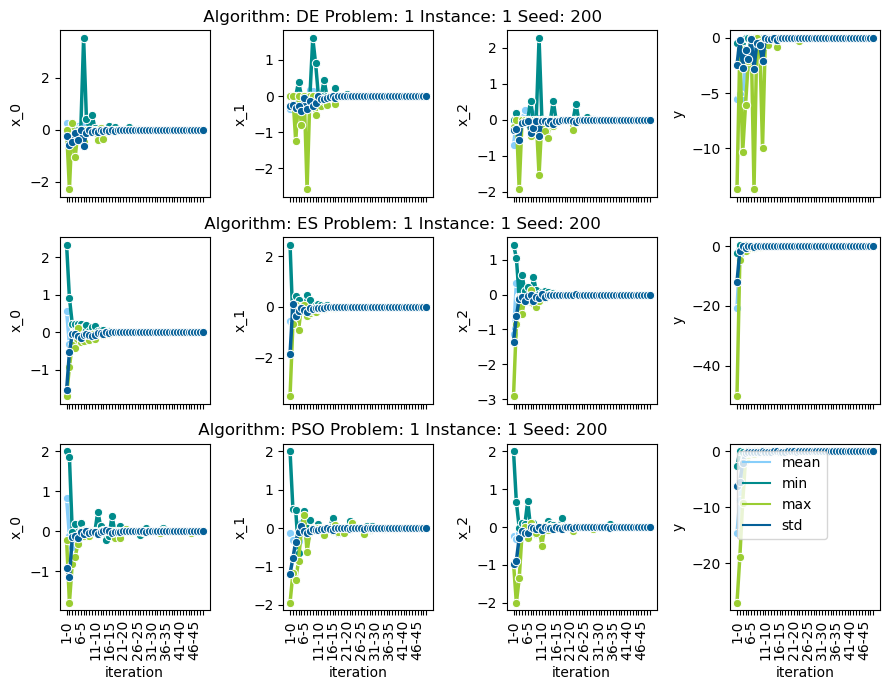

In [75]:
algorithm_names_to_plot=['DE','ES','PSO']
problem_ids_to_plot=[1]
instance_ids_to_plot=[1]
seeds_to_plot=[200]

plot_all_algorithm_trajectories(algorithm_names_to_plot,problem_ids_to_plot, instance_ids_to_plot,seeds_to_plot,difference=True)